In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import ray

ray.init(num_cpus=40)

/srvfs/home/uvoggenberger/micromamba/envs/uv12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-02 10:30:43,954	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-06-02 10:30:46,141	INFO worker.py:1841 -- Started a local Ray instance.


Python version:,3.12.3
Ray version:,2.43.0


(process_station_file pid=1611950) /srvfs/home/uvoggenberger/micromamba/envs/uv12/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
(process_station_file pid=1611950)   return _methods._mean(a, axis=axis, dtype=dtype,
(process_station_file pid=1611950) /srvfs/home/uvoggenberger/micromamba/envs/uv12/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
(process_station_file pid=1611950)   ret = ret.dtype.type(ret / rcount)
(process_station_file pid=1611973) /srvfs/home/uvoggenberger/micromamba/envs/uv12/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice. [repeated 38x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(process_station_file pid=1611973)   r

In [2]:
def z_to_p_ifs(h): # geopotential height (m^/s^2) to pressure (Pa)
    a = 5.252368255329
    b = 44330.769230769
    c = 0.000157583169442
    ptro = 226.547172
    po = 1013.25
    g = 9.80665
 
    h /= g
    if h != h:

        p = h

    elif h > 11000.0:

        y = -c * (h - 11000.0)

        p = ptro * np.exp(y)

    else:

        y = 1.0 - h / b

        p = po * (y**a)

    return p * 100. # we want Pa

In [3]:
@ray.remote
def process_station_file(file):

    with h5py.File(file, 'r') as fl:
        x = fl['observations_table']['observed_variable'][:]
        val = fl['observations_table']['observation_value'][:]
        p = fl['observations_table']['z_coordinate'][:]
        rid_raw = fl['observations_table']['report_id'][:]
        lat = fl['observations_table']['latitude'][:]
        lon = fl['observations_table']['longitude'][:]

    # Convert report_id to strings
    report_ids = ["".join(byte.decode() for byte in rid).strip() for rid in rid_raw]

    # Group by report_id
    from collections import defaultdict
    report_obs = defaultdict(list)

    for var, v, pr, rid, la, lo in zip(x, val, p, report_ids, lat, lon):
        report_obs[rid].append((var, v, pr, la, lo))

    results_temp = []
    results_pilot = []

    for rid, obs in report_obs.items():
        observed_vars = [o[0] for o in obs]
        has_126 = 126 in observed_vars

        # Filter pressure
        obs_200_400 = [o for o in obs if 27000 <= o[2] <= 32000]
        if not obs_200_400:
            continue

        u_vals = [o[1] for o in obs_200_400 if o[0] == 139]
        v_vals = [o[1] for o in obs_200_400 if o[0] == 140]

        if not u_vals or not v_vals:
            continue

        u_mean = np.mean(u_vals)
        v_mean = np.mean(v_vals)
        lat_m = obs_200_400[0][3] 
        lon_m = obs_200_400[0][4] 
        result = (lat_m, lon_m, u_mean, v_mean)

        if has_126:
            results_temp.append(result)
        else:
            results_pilot.append(result)

    lat = []
    lon = []
    u = []
    v = []
    for entry in results_pilot:
        lat.append(entry[0]) 
        lon.append(entry[1]) 
        u.append(entry[2]) 
        v.append(entry[3]) 
    results_pilot = [np.mean(lat), np.mean(lon), np.mean(u), np.mean(v)]

    lat = []
    lon = []
    u = []
    v = []
    for entry in results_temp:
        lat.append(entry[0]) 
        lon.append(entry[1]) 
        u.append(entry[2]) 
        v.append(entry[3]) 
    results_temp = [np.mean(lat), np.mean(lon), np.mean(u), np.mean(v)]    

    return [results_temp, results_pilot]


In [4]:
@ray.remote
def process_station_file_pseudo_pilot(file):

    with h5py.File(file, 'r') as fl:
        x = fl['observations_table']['observed_variable'][:]
        val = fl['observations_table']['observation_value'][:]
        p = fl['observations_table']['z_coordinate'][:]
        rid_raw = fl['observations_table']['report_id'][:]
        lat = fl['observations_table']['latitude'][:]
        lon = fl['observations_table']['longitude'][:]

    # Convert report_id to strings
    report_ids = ["".join(byte.decode() for byte in rid).strip() for rid in rid_raw]

    # Group by report_id
    from collections import defaultdict
    report_obs = defaultdict(list)

    for var, v, pr, rid, la, lo in zip(x, val, p, report_ids, lat, lon):
        report_obs[rid].append((var, v, pr, la, lo))

    results_temp = []
    results_pilot = []
    results_pseudo_pilot = []

    for rid, obs in report_obs.items():
        observed_vars = [o[0] for o in obs]
        if not 126 in observed_vars:
            continue
        
        # Open a wider window for pressure conversion:
        obs_100_500 = [o for o in obs if 10000 <= o[2] <= 50000]

        u_vals = [o[1] for o in obs_100_500 if o[0] == 139]
        v_vals = [o[1] for o in obs_100_500 if o[0] == 140]
        g_vals = [o[1] for o in obs_100_500 if o[0] == 117]

        # Ensure all data is of the same shape:
        if len(g_vals) != len(u_vals) or len(g_vals) == 0:
            continue
        
        # Convert geopotential height to pressure using IFS formula
        p_vals = [z_to_p_ifs(i_g) for i_g in g_vals]

        # Recreate obs with only u_vals, v_vals, lat, lon, and use p_vals as pressure
        obs_uv = []
        i_g_v = 0
        i_g_u = 0
        for idx, (var, v, pr, la, lo) in enumerate(obs_100_500):
            if var in [139]:
                obs_uv.append((var, v, p_vals[i_g_u], la, lo))
                i_g_u += 1
            if var in [140]:
                obs_uv.append((var, v, p_vals[i_g_v], la, lo))
                i_g_v += 1
                
        # Filter pressure as usual:
        obs_200_400 = [o for o in obs_uv if 27000 <= o[2] <= 32000]
        if not obs_200_400:
            continue

        u_vals = [o[1] for o in obs_200_400 if o[0] == 139]
        v_vals = [o[1] for o in obs_200_400 if o[0] == 140]

        if not u_vals or not v_vals:
            continue

        u_mean = np.mean(u_vals)
        v_mean = np.mean(v_vals)
        lat_m = obs_200_400[0][3] 
        lon_m = obs_200_400[0][4] 
        result = (lat_m, lon_m, u_mean, v_mean)

        results_temp.append(result)

    lat = []
    lon = []
    u = []
    v = []
    for entry in results_temp:
        lat.append(entry[0]) 
        lon.append(entry[1]) 
        u.append(entry[2]) 
        v.append(entry[3]) 
    results_temp = [np.mean(lat), np.mean(lon), np.mean(u), np.mean(v)]    

    return [results_temp]

In [5]:
def plot_station_winds_uv(results, wind='u', vma = -50, vmi = 50, title="Wind Components (400–200 hPa)"):

    lats = [r[0] for r in results] # if not np.isnan(r[0])]
    lons = [r[1] for r in results] # if not np.isnan(r[1])]
    us = [r[2] for r in results] # if not np.isnan(r[2])]
    vs = [r[3] for r in results] # if not np.isnan(r[3])]

    if len(lats) == 0 or len(lons) == 0 or len(us) == 0 or len(vs) == 0:
        print("No valid data to plot.")
        return

    plt.figure(figsize=(16, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.gridlines(draw_labels=True)

    # Plot colored scatter plots for u and v components
    if wind == 'u':
        sc_u = ax.scatter(lons, lats, c=us, cmap='coolwarm', s=80, marker='o', edgecolor='k', vmin=vmi, vmax=vma, transform=ccrs.PlateCarree())
        cbar = plt.colorbar(sc_u, ax=ax, orientation='vertical', label='U component (m/s)', shrink=0.7, pad=0.02)
        plt.title(title + " - U component")
        plt.tight_layout()
        plt.show()
        plt.savefig(f"{title.replace(' ', '_').lower()}_u.png", dpi=300)
        plt.close()
    if wind == 'v':
        sc_v = ax.scatter(lons, lats, c=vs, cmap='coolwarm', s=80, marker='o', edgecolor='k', vmin=vmi, vmax=vma, transform=ccrs.PlateCarree())
        cbar = plt.colorbar(sc_v, ax=ax, orientation='vertical', label='V component (m/s)', shrink=0.7, pad=0.02)
        plt.title(title + " - V component")
        plt.tight_layout()
        plt.show()
        plt.savefig(f"{title.replace(' ', '_').lower()}_v.png", dpi=300)
        plt.close()




In [6]:
files = glob.glob("/mnt/users/scratch/leo/scratch/converted_v29/1985/*.nc", recursive=True)[:]
# results = process_station_file(files[0])
futures = [process_station_file.remote(f) for f in files]
results = ray.get(futures)


In [7]:
files = glob.glob("/mnt/users/scratch/leo/scratch/converted_v29/1985/*.nc", recursive=True)[:]
futures = [process_station_file_pseudo_pilot.remote(f) for f in files]
results_pseudo = ray.get(futures)


In [8]:
rn = np.array(results)[:,0,:]
rp = np.array(results)[:,1,:]
rpp = np.array(results_pseudo)[:,0,:]

In [9]:
def result_difference(rn, rp, threshold = 0.1):
    mask1 = ~np.isnan(rn[:,0]) & ~np.isnan(rn[:,1])
    mask2 = ~np.isnan(rp[:,0]) & ~np.isnan(rp[:,1])

    valid1 = rn[mask1]
    valid2 = rp[mask2]

    # Lists to store results
    matched_rows = []

    # Loop through array1 entries
    for row1 in valid1:
        x1, y1 = row1[0], row1[1]
        
        # Compute distances to all array2 entries
        dx = np.abs(valid2[:, 0] - x1)
        dy = np.abs(valid2[:, 1] - y1)
        
        # Find indices where both differences are within threshold
        close_indices = np.where((dx <= threshold) & (dy <= threshold))[0]
        
        if close_indices.size > 0:
            # Pick the first matching row (or you can refine this to pick the closest!)
            idx2 = close_indices[0]
            row2 = valid2[idx2]
            
            # Differences in third and fourth columns
            diff_col2 = row1[2] - row2[2]
            diff_col3 = row1[3] - row2[3]
            
            # Save: [x, y, diff_col2, diff_col3]
            matched_rows.append([x1, y1, diff_col2, diff_col3])

    # Convert to NumPy array
    result = np.array(matched_rows)

    return(result)


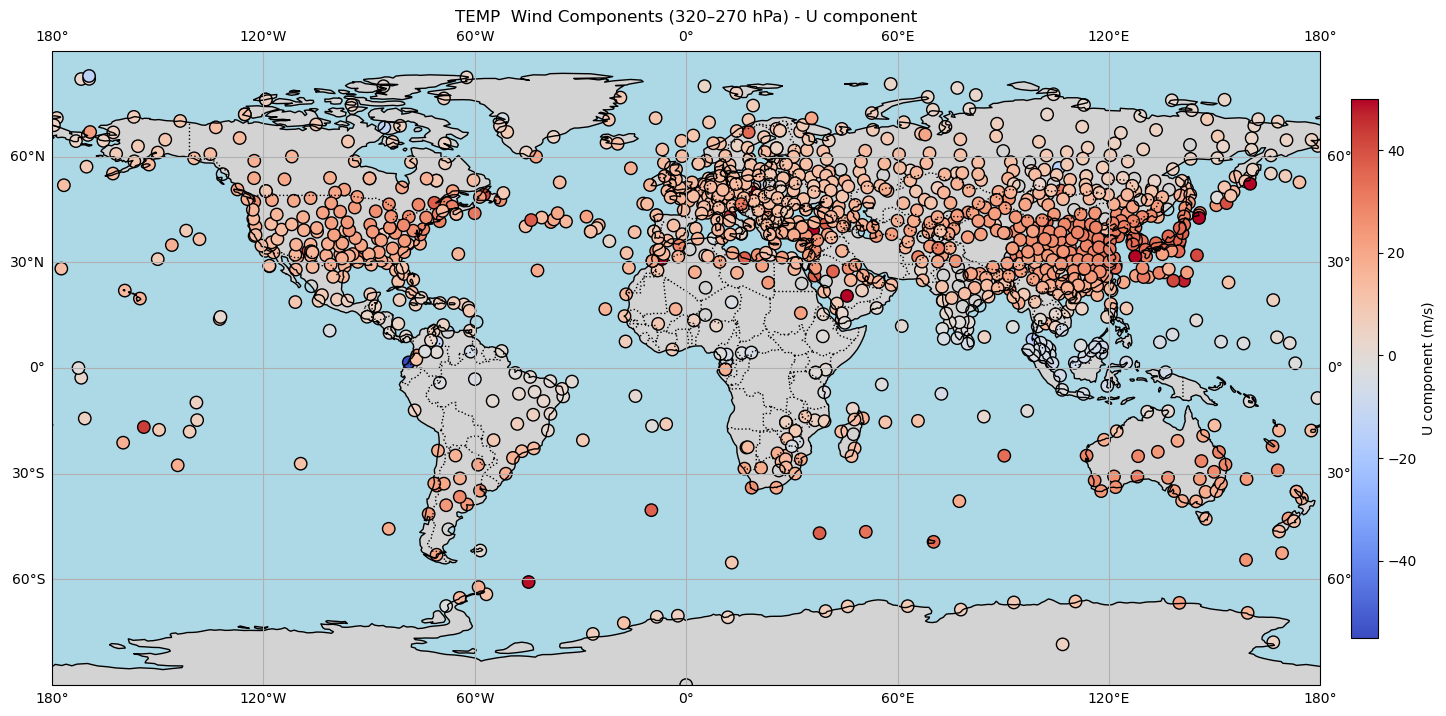

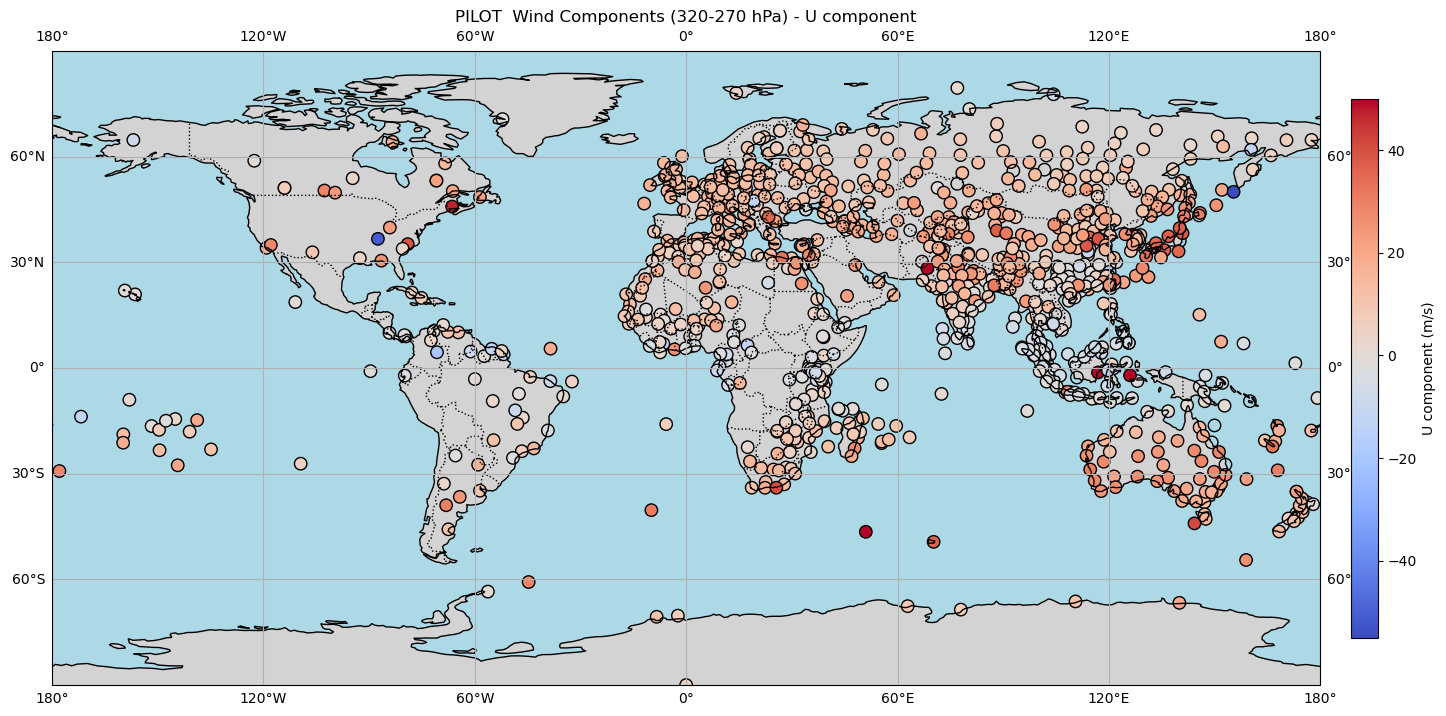

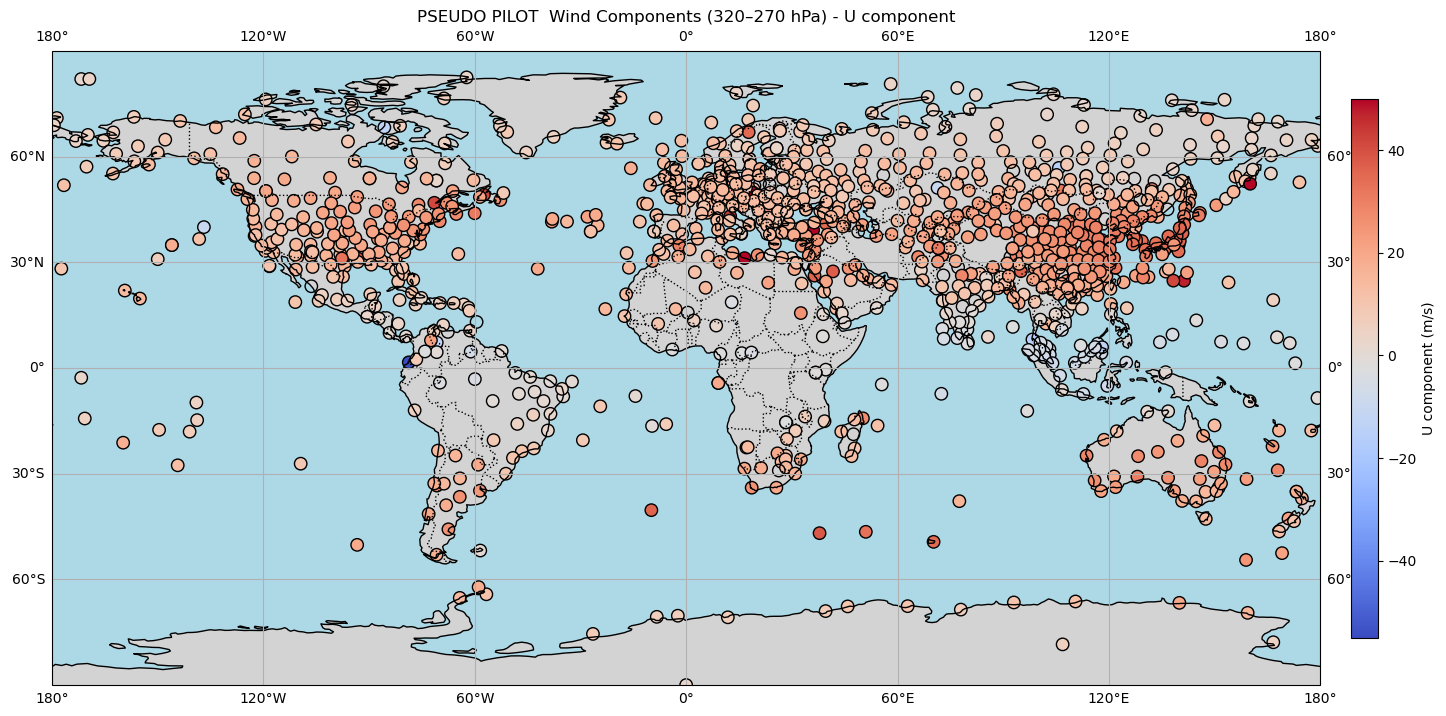

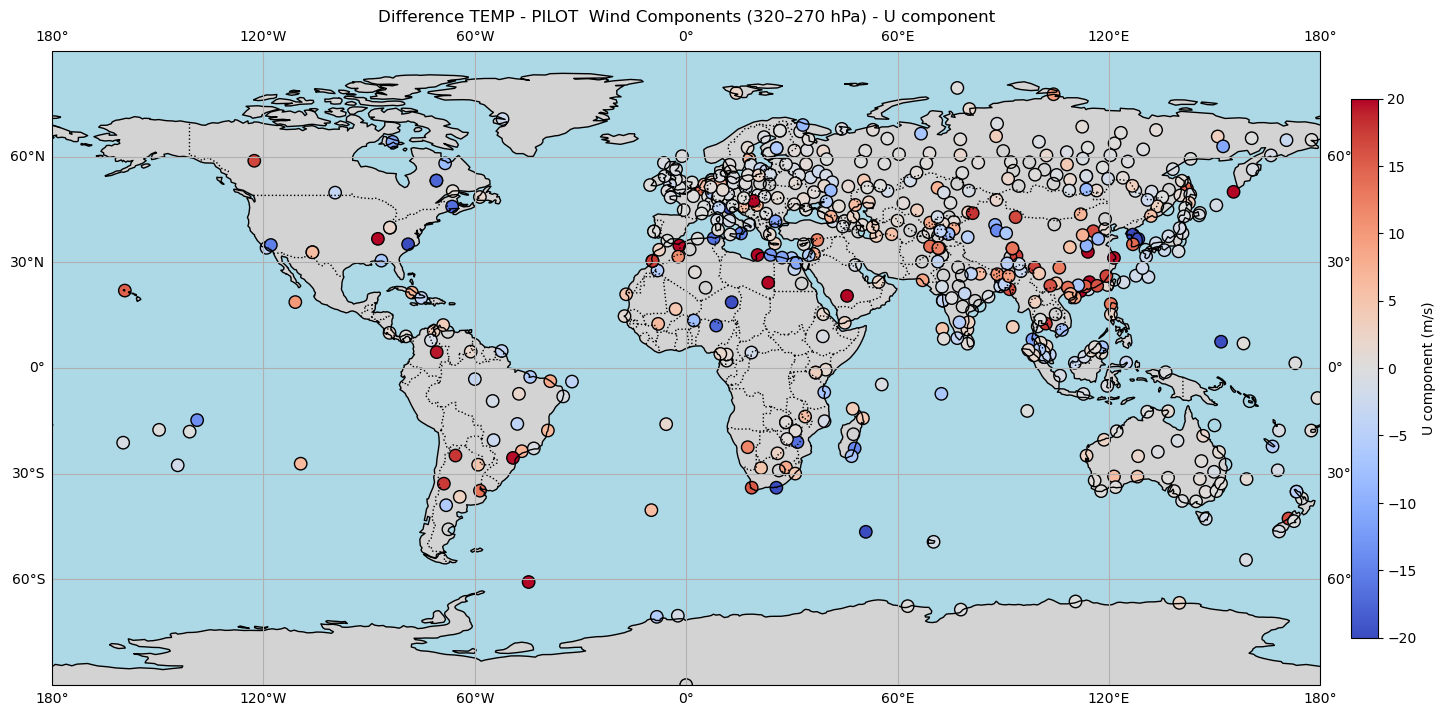

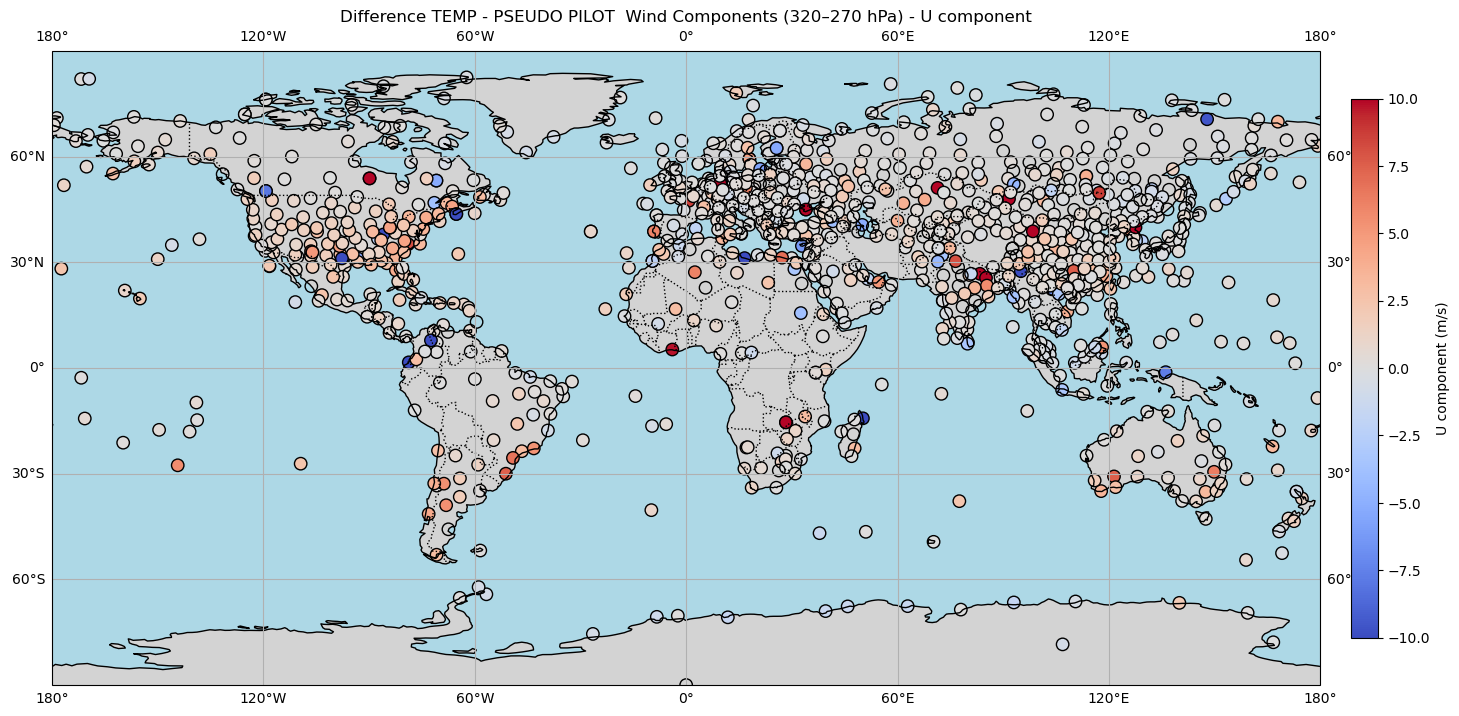

In [11]:
plot_station_winds_uv(np.array(results)[:,0,:], wind='u', title="TEMP  Wind Components (320–270 hPa)")
plot_station_winds_uv(np.array(results)[:,1,:], wind='u', title="PILOT  Wind Components (320-270 hPa)")
plot_station_winds_uv(np.array(results_pseudo)[:,0,:], wind='u', title="PSEUDO PILOT  Wind Components (320–270 hPa)")
plot_station_winds_uv(result_difference(rn, rp), wind='u', title="Difference TEMP - PILOT  Wind Components (320–270 hPa)", vmi = -20, vma = 20)
plot_station_winds_uv(result_difference(rn, rpp), wind='u', title="Difference TEMP - PSEUDO PILOT  Wind Components (320–270 hPa)", vmi = -10, vma = 10)
